# Proyecto 4: Redes Neuronales en Serie de Tiempo

+ Con este proyecto se desea abordar el tema de Redes Neuronales, para poner en práctica la teoria vista y mirar si estos nuevos modelos de Deep Learning superan a los modelos clásicos como lo son el ARIMA.
+ ¿Las Redes Neuronales modelarán y pronosticarán mejor que el modelo ARIMA, en esta serie de tiempo?

Tabla A: **Cuadro de Resultados de Metricas MSE, MAE, MAPE, R2 Y RMSE**

|Modelo         |   MSE    |  MAE   | MAPE   |  R2  | RMSE |
|:--------------|:--------:|:------:|:------:|:----:|-----:|
|ARIMA(6,1,7)   |23547549.9|3523.99 |0.122116|0.2991|4852.5|
|**ARIMA(5,1,5)**   |19145490.1|3196.01 |0.116974|0.4301|**4375.5**|
|SARIMA         |34493076.8|4601.94 |0.116974|-0.018|5873.0|
|RandomForest-os|21942432.2|3324.81 |0.098590|0.2283|4684.2|
|RandomForest-ms|23786710.5|3407.70 |0.123032|0.1635|4877.1|  
|Prophet con Fes|39524932.8|4777.67 |0.133219|-0.253|6286.8| 
|Prophet sin Fes|35947219.5|4424.10 |0.101140|-0.140|5995.6| 
|**ARIMA(2,1,2) +** |12640386.6|2608.24 |0.112749|0.5122|**3555.3**|
|Prophet +      |43559470.2|5047.42 |0.138128|-0.723|6599.9|

La tabla A, muestra los resultados de las métricas halladas en el proyecto 3 de los diferentes modelos implementados. 

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

#Librerias
# exploración de datos
import matplotlib.pyplot as plt
#exploración de datos
import seaborn as sns
# Mejorar el estilo de los gráficos
sns.set()
# fechas
import datetime #Para manipular fechas

import matplotlib.mlab as mlab
import math
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima_model import ARIMA

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from matplotlib.pylab import rcParams

import itertools

In [3]:
data_2019 = pd.read_csv('../Proyecto 3/flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('../Proyecto 3/flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('../Proyecto 3/flujo-vehicular-2017.csv', sep =',')

In [4]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01,2,Martes,Centro,Liviano,537
86,2019-01-01,2,Martes,Centro,Pesado,1
88,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019-01-01,3,Martes,Centro,Liviano,769


In [5]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [6]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [7]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


In [8]:
#Resampleamos SUMA nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


<ipython-input-9-2aecb540042e>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(diario['2017'].values)
<ipython-input-9-2aecb540042e>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(diario['2018'].values)
<ipython-input-9-2aecb540042e>:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(diario['2019'].values)


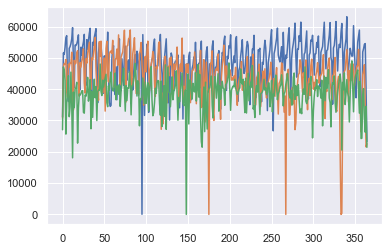

In [9]:
plt.plot(diario['2017'].values)
plt.plot(diario['2018'].values)
plt.plot(diario['2019'].values)

In [10]:
diario.cantidad_pasos[diario.cantidad_pasos < 20000] = np.nan

In [11]:
diario.isna().sum()

cantidad_pasos    8
dtype: int64

In [12]:
print(diario.isna().sum())
diario = diario.interpolate()
print(diario.isna().sum())

cantidad_pasos    8
dtype: int64
cantidad_pasos    0
dtype: int64


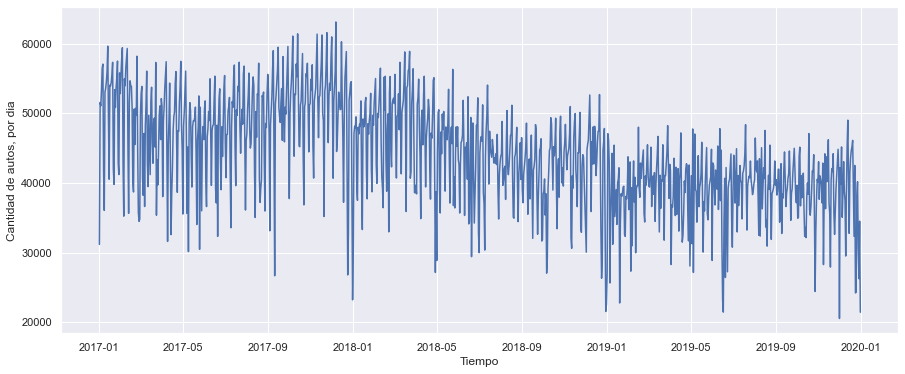

In [13]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [14]:
print(diario.index.min())
print(diario.index.max())

2017-01-01 00:00:00
2019-12-31 00:00:00


In [15]:
print(len(diario['2017']))
print(len(diario['2018']))
print(len(diario['2019']))

365
365
365


<ipython-input-15-e63a57fafc5a>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  print(len(diario['2017']))
<ipython-input-15-e63a57fafc5a>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  print(len(diario['2018']))
<ipython-input-15-e63a57fafc5a>:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  print(len(diario['2019']))


In [16]:
diario.describe()

,cantidad_pasos
count,1095.000000
mean,43973.251142
std,7472.356274
min,20553.000000
25%,39128.500000
50%,43766.000000
75%,49514.500000
max,63127.000000


# Red Neuronal FeedForward

Esta red neuronal tambien es llamada MLP por sus siglas en inglés Multi-Layered Perceptron.

In [17]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import tensorflow.keras as kr

Se tomará la serie temporal y la convertiremos en un problema tipo supervisado, así se alimentará la red neuronal y para poder entrenarla con backpropagation. Tomaremos 30 días, que se pueden modificar por otro valor, para entrenar la red.
Para hacer la transformación usaremos la funcion **series_to_supervised()**.
A continuación, vemos como queda el set de datos de entrada:

In [18]:
PASOS=30

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else diario.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
values = diario.values
# ensure all data is float
values = values.astype('float32')
# normalize features
#scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
#scaled = scaler.fit_transform(values)
# frame as supervised learning
#reframed = series_to_supervised(scaled, PASOS, 1)
reframed = series_to_supervised(values, PASOS, 1)
reframed.head()


,var1(t-30),var1(t-29),var1(t-28),var1(t-27),var1(t-26),var1(t-25),var1(t-24),var1(t-23),var1(t-22),var1(t-21),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
30,31183.0,51568.0,51093.0,53332.0,56486.0,57081.0,41587.0,36065.0,53036.0,53601.0,...,39804.0,53409.0,50855.0,53657.0,55105.0,57506.0,42831.0,41218.0,55814.0,52842.0
31,51568.0,51093.0,53332.0,56486.0,57081.0,41587.0,36065.0,53036.0,53601.0,54523.0,...,53409.0,50855.0,53657.0,55105.0,57506.0,42831.0,41218.0,55814.0,52842.0,55616.0
32,51093.0,53332.0,56486.0,57081.0,41587.0,36065.0,53036.0,53601.0,54523.0,56042.0,...,50855.0,53657.0,55105.0,57506.0,42831.0,41218.0,55814.0,52842.0,55616.0,57795.0
33,53332.0,56486.0,57081.0,41587.0,36065.0,53036.0,53601.0,54523.0,56042.0,59651.0,...,53657.0,55105.0,57506.0,42831.0,41218.0,55814.0,52842.0,55616.0,57795.0,59423.0
34,56486.0,57081.0,41587.0,36065.0,53036.0,53601.0,54523.0,56042.0,59651.0,49014.0,...,55105.0,57506.0,42831.0,41218.0,55814.0,52842.0,55616.0,57795.0,59423.0,42667.0


En el siguiente paso, se subdividirá el set de datos en train y test. Por lo tanto, haremos una subdivisión de los primeros 1005 días consecutivos para entrenar la red, y los siguientes 60 días para su validación.

In [23]:
# split into train and test sets
values = reframed.values
n_train_days = 1095 - (60+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(1005, 1, 30) (1005,) (60, 1, 30) (60,)


Hemos transformado la entrada en un arreglo con forma (1005,1,30) lo que quiere decir que son 1005 entradas con vectores de 1x30.

La arquitectura de la Red Neuronal Será:

+ Entrada de 30 inputs
+ 1 capa oculta con 30 neuronas
+ Como función de activación se utilizará ReLu: f(x) = 0, si x<0, x>=0
+ Se utilizará como optimizador Adam y métrica de pérdida (loss) Mean Absolute Error
+ Como la predicción será un valor continuo, para calcular el Acuracy se utilizará el Mean Squared Error, este debería ir reduciendo con los EPOCHS para notar la mejora.

In [24]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [30]:
EPOCHS=30
model = crear_modeloFF()
historyA=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1, 30)             930       
_________________________________________________________________
flatten_2 (Flatten)          (None, 30)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 31        
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
34/34 [==============================] - 0s 3ms/step - loss: 7670.1631 - mse: 104055120.0000 - val_loss: 5536.6865 - val_mse: 57082316.0000
Epoch 2/30
34/34 [==============================] - 0s 1ms/step - loss: 4973.9370 - mse: 43093272.0000 - val_loss: 5244.7437 - val_mse: 45554944.0000
Epoch 3/30
34/34 [==============================] - 0s 1ms/step - loss: 4720.4961 - m

In [31]:
results=model.predict(x_val)

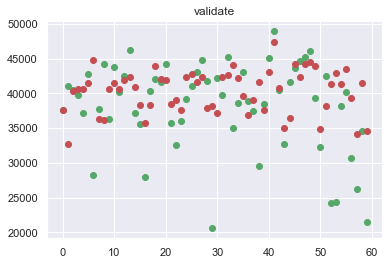

In [32]:
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

En la gráfica anterior podemos ver que los puntos verdes (valores de validación) intentan aproximarse a los rojos, cuanto más cerca o superpuestos mejor. Cabe destacar que la predicción no se acopla a los valores de validación.

In [33]:
print(historyA.history.keys())

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


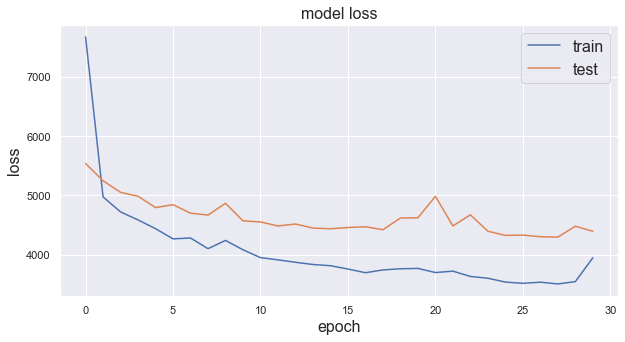

In [36]:
# summarize history for accuracy
rcParams['figure.figsize']=10,5
plt.plot(historyA.history['loss'])
plt.plot(historyA.history['val_loss'])
plt.title('model loss',fontsize=16)
plt.ylabel('loss',fontsize=16)
plt.xlabel('epoch',fontsize=16)
plt.legend(['train', 'test'], loc=1 ,prop={'size': 16})
plt.show()

Se puede observar que la Red neuronal se entreba correctamente, ya que su error disminuye a traves del tiempo. Y a su vez, se puede sugerir que no hay overfitting, pues las curvas de train y test son distintas.

In [37]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from sklearn.metrics import r2_score

In [38]:
#strt='2019-12-31'
#end='2020-12-31'
#predic = forecastR[(forecastR['ds']>strt) & (forecastR['ds']<=end)]

print('MAE:', metrics.mean_absolute_error(y_val, results))
print('MSE:', metrics.mean_squared_error(y_val, results))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_val, results)))

MAE: 4393.99
MSE: 39520716.0
RMSE: 6286.5503


In [39]:
mape = np.mean(np.abs(results - y_val)/np.abs(y_val))
print('MAPE: '+str(mape))

MAPE: 0.17137223


In [40]:
#print('R2 train:',r2_score(y_train,y_train_pred))
print('R2 test:', r2_score(y_val, results))

R2 test: 0.024108895676672293


## Red Neuronal Recurrente

Las Redes Neuronales Recurrentes (RNN, po sus siglas en inglés), se utliza para procesar datos secuenciales como las series de tiempo. El LSTM es un tipo especial de RNN que se compone de una capa de entrada, otra de salida y una serie de capas ocultas conectadas de forma recurrente.

In [41]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from matplotlib.pylab import rcParams

import itertools

In [42]:
#upsampled = dataset.resample('D', on = 'fecha').sum()

diario = dataset.resample('D', on = 'fecha').sum()

In [43]:
diario.cantidad_pasos[diario.cantidad_pasos < 20000] = np.nan

In [44]:
diario.isna().sum()

cantidad_pasos    8
dtype: int64

In [45]:
print(diario.isna().sum())
diario = diario.interpolate()
print(diario.isna().sum())

cantidad_pasos    8
dtype: int64
cantidad_pasos    0
dtype: int64


In [46]:
diario.head()

,cantidad_pasos
fecha,
2017-01-01,31183.0
2017-01-02,51568.0
2017-01-03,51093.0
2017-01-04,53332.0
2017-01-05,56486.0


In [47]:
#len(interpolated)
#df = interpolated
#df = df.reset_index()
TEST_SIZE = 100
train, test = diario.iloc[:-TEST_SIZE], diario.iloc[-TEST_SIZE:]


Para la implementación del algoritmo LSTM es necesario normalizar el conjunto de datos, se optará para esta función la normalización Minimo Máximo de la librería sklearn.

In [48]:
from sklearn.preprocessing import MinMaxScaler

train_data = train['cantidad_pasos'].values
print(train_data.shape) 

# normalización antes de alimentar a LSTM usando sklearn:
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

scaler.fit(train_data)
train_data = scaler.transform(train_data)

(995,)


In [49]:
''' Función para crear un conjunto de datos para alimentar a LSTM'''
def create_dataset(data, look_back):
    dataX, dataY = [], []
    for i in range(len(data)-look_back):
        a = data[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
    
    
# Crear conjunto train:
time_steps = 36
X_train, Y_train = create_dataset(train_data, time_steps)

# reshape it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 36, 1))

print(X_train.shape)


# Visualizar data train 
print('X_train:')
print(str(scaler.inverse_transform(X_train[0])))
print("\n")
print('y_train: ' + str(scaler.inverse_transform(Y_train[0].reshape(-1,1)))+'\n')

(959, 36, 1)
X_train:
[[31183.]
 [51568.]
 [51093.]
 [53332.]
 [56486.]
 [57081.]
 [41587.]
 [36065.]
 [53036.]
 [53601.]
 [54523.]
 [56042.]
 [59651.]
 [49014.]
 [40546.]
 [54061.]
 [53940.]
 [54468.]
 [55548.]
 [57337.]
 [42057.]
 [39804.]
 [53409.]
 [50855.]
 [53657.]
 [55105.]
 [57506.]
 [42831.]
 [41218.]
 [55814.]
 [52842.]
 [55616.]
 [57795.]
 [59423.]
 [42667.]
 [35244.]]


y_train: [[54963.]]



**A continuación se construye la Red Neuronal**

+ Número de capas: dos capas LSTM con 500 unidades, dos capas Dropout de 0.5 y una capa densa de una única neurona. Se añade una capa Dropout luego de la capa LSTM con el objetivo de evitar el Overfitting.
+ Número de epocas de entrenamiento (epoch): 50
+ Función de perdida (loss), define el objetivo de minimizar el error cuadrático medio entre los valores predichos y los valores de prueba durante el entrenamiento.
+ Función de optimización se utilizará Adam

In [50]:
# Construye el modelo
model = keras.Sequential()

model.add(LSTM(units = 500, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.5))

model.add(LSTM(units = 500))
model.add(Dropout(0.5))

# salida
model.add(Dense(units = 1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 36, 500)           1004000   
_________________________________________________________________
dropout (Dropout)            (None, 36, 500)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 500)               2002000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 501       
Total params: 3,006,501
Trainable params: 3,006,501
Non-trainable params: 0
_________________________________________________________________


In [51]:

# Compilar el modelo
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Entrenar 
history = model.fit(X_train, Y_train, epochs = 50, batch_size = 20, validation_split=.30)

Epoch 1/50
34/34 [==============================] - 14s 419ms/step - loss: 0.0827 - val_loss: 0.0203
Epoch 2/50
34/34 [==============================] - 14s 399ms/step - loss: 0.0305 - val_loss: 0.0177
Epoch 3/50
34/34 [==============================] - 14s 399ms/step - loss: 0.0304 - val_loss: 0.0196
Epoch 4/50
34/34 [==============================] - 14s 401ms/step - loss: 0.0284 - val_loss: 0.0318
Epoch 5/50
34/34 [==============================] - 13s 397ms/step - loss: 0.0294 - val_loss: 0.0168
Epoch 6/50
34/34 [==============================] - 14s 419ms/step - loss: 0.0289 - val_loss: 0.0193
Epoch 7/50
34/34 [==============================] - 15s 432ms/step - loss: 0.0282 - val_loss: 0.0251
Epoch 8/50
34/34 [==============================] - 15s 433ms/step - loss: 0.0281 - val_loss: 0.0213
Epoch 9/50
34/34 [==============================] - 14s 404ms/step - loss: 0.0285 - val_loss: 0.0168
Epoch 10/50
34/34 [==============================] - 14s 405ms/step - loss: 0.0267 - val_lo

In [52]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


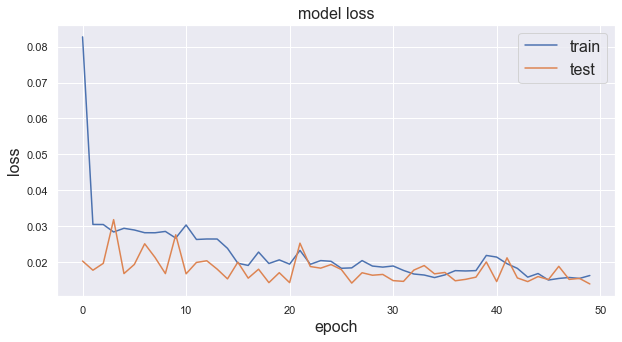

In [53]:
# summarize history for accuracy
rcParams['figure.figsize']=10,5
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss',fontsize=16)
plt.ylabel('loss',fontsize=16)
plt.xlabel('epoch',fontsize=16)
plt.legend(['train', 'test'], loc=1 ,prop={'size': 16})
plt.show()

Después de generar el modelo de Red Neuronal, se puede observar que se ha entrenado correctamente, ya que los valores de error disminuyen a traves de cada época.

In [54]:

test_data = test['cantidad_pasos'].values
test_data = test_data.reshape(-1,1)
test_data = scaler.transform(test_data)

# Create the data to test our model on:
time_steps = 36
X_test, y_test = create_dataset(test_data, time_steps)


# store the original vals for plotting the predictions 
y_test = y_test.reshape(-1,1) 
org_y = scaler.inverse_transform(y_test)

# reshape it [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], 36, 1))

# Predict the prices with the model
predicted_y = model.predict(X_test)
predicted_y = scaler.inverse_transform(predicted_y)

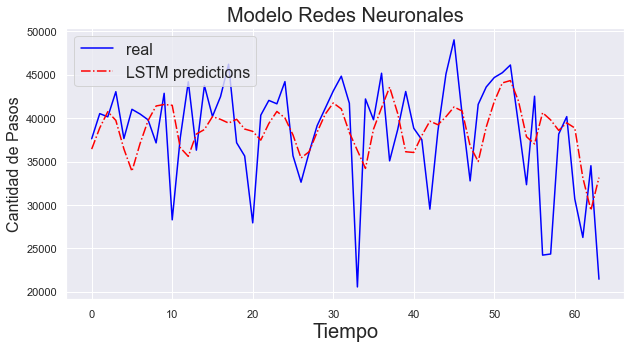

In [55]:
# plot the results 
rcParams['figure.figsize']=10,5
plt.plot(org_y, color = 'blue',  label= 'real' )
plt.plot(predicted_y, color = 'red', ls='-.', label = 'LSTM predictions')
plt.title('Modelo Redes Neuronales',fontsize=20)
plt.xlabel('Tiempo' ,fontsize=20 )
plt.ylabel("Cantidad de Pasos", fontsize=16)
plt.legend(loc=2, prop={'size': 16})
plt.show()

Se puede observar en la anterior gráfica, que la predicción no se ajusta muy bien a los picos que tiene la serie Real, sin embargo, podemos aumentar las carateristicas de la Red Neuronal para que se ajuste mejor. Pero, se corre el riesgo de sobreajuste y el costo computacional puede ser muy alto.

In [56]:
import math
from sklearn.metrics import mean_squared_error

act = [i[0] for i in org_y] 
pred = [i[0] for i in predicted_y] 
print(act)
print(pred)

[37630.0, 40527.0, 40159.0, 43053.0, 37655.0, 41024.0, 40486.0, 39814.0, 37153.0, 42866.0, 28286.0, 37738.0, 44193.00000000001, 36314.0, 43761.0, 40201.0, 42486.0, 46215.99999999999, 37172.0, 35640.0, 27937.0, 40345.0, 42049.0, 41656.0, 44214.99999999999, 35675.0, 32623.0, 36038.0, 39138.0, 41133.0, 43130.0, 44841.0, 41722.0, 20553.0, 42215.0, 39820.0, 45181.0, 35084.0, 38676.0, 43076.0, 38839.0, 37518.0, 29518.000000000004, 38546.0, 45099.0, 49027.0, 40478.0, 32774.0, 41588.0, 43597.0, 44687.0, 45241.00000000001, 46127.99999999999, 39303.0, 32336.999999999996, 42531.00000000001, 24220.000000000004, 24349.0, 38168.0, 40182.0, 30681.0, 26259.0, 34523.0, 21446.999999999996]
[36436.695, 38878.72, 40753.883, 39742.812, 36457.875, 33884.69, 37053.125, 39724.02, 41407.91, 41578.867, 41486.215, 36603.047, 35597.008, 38171.855, 38695.55, 40178.434, 39866.13, 39438.945, 39873.867, 38749.02, 38482.793, 37473.03, 39386.76, 40776.75, 40032.477, 38069.984, 35411.95, 36135.074, 38389.445, 40459.82, 

In [57]:
print('MAE:', metrics.mean_absolute_error(act, pred))
print('MSE:', metrics.mean_squared_error(act, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(act, pred)))

MAE: 4349.933929443359
MSE: 34839069.982828915
RMSE: 5902.463043749525


In [58]:
#print('R2 train:',r2_score(y_train,y_train_pred))
print('R2 test:', r2_score(act, pred))

R2 test: 0.09416935570837226


In [59]:
act = np.array(act)
pred = np.array(pred)

In [60]:
mape = np.mean((np.abs(pred - act))/np.abs(act))
print('MAPE: '+str(mape))

MAPE: 0.13334221712325528


Tabla B: **Cuadro de Resultados de Metricas MSE, MAE, MAPE, R2 Y RMSE con los modelos de Redes Neuronales**

|Modelo         |   MSE    |  MAE   | MAPE   |  R2  | RMSE |
|:--------------|:--------:|:------:|:------:|:----:|-----:|
|ARIMA(6,1,7)   |23547549.9|3523.99 |0.122116|0.2991|4852.5|
|**ARIMA(5,1,5)**   |19145490.1|3196.01 |0.116974|0.4301|**4375.5**|
|SARIMA         |34493076.8|4601.94 |0.116974|-0.018|5873.0|
|RandomForest-os|21942432.2|3324.81 |0.098590|0.2283|4684.2|
|RandomForest-ms|23786710.5|3407.70 |0.123032|0.1635|4877.1|  
|Prophet con Fes|39524932.8|4777.67 |0.133219|-0.253|6286.8| 
|Prophet sin Fes|35947219.5|4424.10 |0.101140|-0.140|5995.6| 
|**ARIMA(2,1,2) +** |12640386.6|2608.24 |0.112749|0.5122|**3555.3**|
|Prophet +      |43559470.2|5047.42 |0.138128|-0.723|6599.9|
|RNF            |25636130.0|3516.89 |0.127763|0.0067|5063.2|
|RNN            |35420026.4|4224.31 |0.128347|0.0790|5951.4|


La Red Neuronal Recurrente (RNN) y la Red Neuronal FeedForward (RNF), según los resultados de sus metricas, no alcanza a superar a los modelos ARIMA que tienen la mejores metricas evaluadas y comparadas en la Tabla B. Sin embargo, se puede experimentar modificando y aumentando el número de neuronas, número de epocas de entrenamieto (epoch) para que la neurona tenga la posibilidad de aprender más especificamente y mejorar sus métricas. Sin embargo, hay un costo computacional alto y hay que estar alertas al sobre ajuste.

Se esperaba un poco más de estos modelos de Redes Neuronales, se estaba a la expectativa de que con un modelo sencillo pudiera generalizar y mejorar en sus metricas. Sin embargo, al parecer hay que complejizar más la red neuronal para que pueda comprender los movimientos de la serie de tiempo.

Lo que hace concluir que el mejor modelo para modelar esta serie de tiempo es el ARIMA(2,1,2) un modelo sencillo pero que supera a los otros modelos evaluados.

Referencias

[1] https://www.aprendemachinelearning.com/pronostico-de-series-temporales-con-redes-neuronales-en-python/

[2] http://openaccess.uoc.edu/webapps/o2/bitstream/10609/123386/6/nsanchezpoTFM0620memoria.pdf

**Tarea:** Implementar modelos con variables exogenas

In [210]:
!pip install pmdarima

#import lightgbm as lgb
import numpy as np
import pandas as pd

from fbprophet import Prophet
from matplotlib import pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.style as style
import zipfile
import json

myfavouritenumber = 13
seed = myfavouritenumber
np.random.seed(seed)

You should consider upgrading via the 'c:\users\camilo\miniconda3\python.exe -m pip install --upgrade pip' command.


In [211]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
datasetB = pd.concat([data_2019, data_2018, data_2017])

In [212]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
datasetB['fecha2'] = pd.to_datetime(datasetB.fecha) + pd.to_timedelta(datasetB.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
datasetB.drop(columns=['fecha','hora_fin'], inplace = True)

In [213]:
datasetB.rename(columns = {'fecha2':'fecha'}, inplace = True) 


In [214]:
datasetB.sort_values('fecha', inplace = True)
datasetB.reset_index(drop=True, inplace = True)


In [215]:
datasetB.drop(columns = ['periodo','hora_inicio'], inplace = True)

In [216]:
#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(datasetB.estacion=='Illia', datasetB.forma_pago == 'EFECTIVO')
datasetB = datasetB[mask]

In [217]:
datasetB.head()

,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha
1,Domingo,Illia,Provincia,Liviano,EFECTIVO,9,2017-01-01
23,Domingo,Illia,Provincia,Liviano,EFECTIVO,644,2017-01-01
40,Domingo,Illia,Provincia,Pesado,EFECTIVO,2,2017-01-01
41,Domingo,Illia,Provincia,Pesado,EFECTIVO,1,2017-01-01
43,Domingo,Illia,Provincia,Pesado,EFECTIVO,1,2017-01-01


<AxesSubplot:>

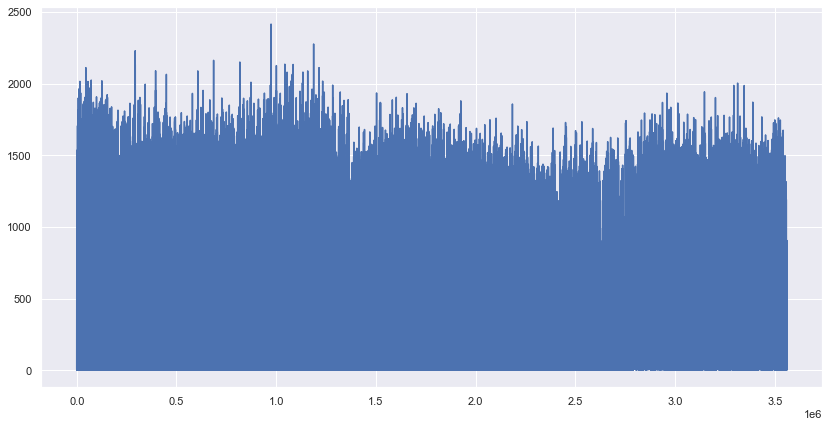

In [218]:
datasetB.cantidad_pasos.plot(figsize=(14, 7))

In [219]:
datasetB.head()

,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha
1,Domingo,Illia,Provincia,Liviano,EFECTIVO,9,2017-01-01
23,Domingo,Illia,Provincia,Liviano,EFECTIVO,644,2017-01-01
40,Domingo,Illia,Provincia,Pesado,EFECTIVO,2,2017-01-01
41,Domingo,Illia,Provincia,Pesado,EFECTIVO,1,2017-01-01
43,Domingo,Illia,Provincia,Pesado,EFECTIVO,1,2017-01-01


Se quiere convertir las caracteristicas como lo son el día, el sentido y el tipo de vehiculo como variables númericas, con el método del Encoding Label o One-Hot Encoding, para explorar si le aportan información a la serie de tiempo.

**ENCODING sentido**

In [220]:
datasetC = datasetB.copy()

In [221]:
#dataA21.tipo_de_propiedad.count_values
datasetC['sentido'].value_counts()

Centro       127696
Provincia    111173
Name: sentido, dtype: int64

In [222]:
datasetC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238869 entries, 1 to 3560700
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   dia             238869 non-null  object        
 1   estacion        238869 non-null  object        
 2   sentido         238869 non-null  object        
 3   tipo_vehiculo   238869 non-null  object        
 4   forma_pago      238869 non-null  object        
 5   cantidad_pasos  238869 non-null  int64         
 6   fecha           238869 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 14.6+ MB


In [223]:
datasetC

print(len(datasetC))
datasetC.head()

238869


,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha
1,Domingo,Illia,Provincia,Liviano,EFECTIVO,9,2017-01-01
23,Domingo,Illia,Provincia,Liviano,EFECTIVO,644,2017-01-01
40,Domingo,Illia,Provincia,Pesado,EFECTIVO,2,2017-01-01
41,Domingo,Illia,Provincia,Pesado,EFECTIVO,1,2017-01-01
43,Domingo,Illia,Provincia,Pesado,EFECTIVO,1,2017-01-01


In [224]:
data_ohe = pd.get_dummies(datasetC['sentido'], drop_first=False)
data_ohe

,Centro,Provincia
1,0,1
23,0,1
40,0,1
41,0,1
43,0,1
...,...,...
3560573,1,0
3560579,1,0
3560619,0,1
3560695,0,1


In [225]:
datasetD = pd.concat([datasetC, data_ohe], axis=1)

In [226]:
y = dataset.cantidad_pasos

In [227]:
datasetD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238869 entries, 1 to 3560700
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   dia             238869 non-null  object        
 1   estacion        238869 non-null  object        
 2   sentido         238869 non-null  object        
 3   tipo_vehiculo   238869 non-null  object        
 4   forma_pago      238869 non-null  object        
 5   cantidad_pasos  238869 non-null  int64         
 6   fecha           238869 non-null  datetime64[ns]
 7   Centro          238869 non-null  uint8         
 8   Provincia       238869 non-null  uint8         
dtypes: datetime64[ns](1), int64(1), object(5), uint8(2)
memory usage: 15.0+ MB


In [228]:
datasetD.head(2)

,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha,Centro,Provincia
1,Domingo,Illia,Provincia,Liviano,EFECTIVO,9,2017-01-01,0,1
23,Domingo,Illia,Provincia,Liviano,EFECTIVO,644,2017-01-01,0,1


**Encoding Tipo de Vehiculo**

In [229]:

datasetD['tipo_vehiculo'].value_counts()

Pesado     151521
Liviano     87348
Name: tipo_vehiculo, dtype: int64

In [230]:
datasetD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238869 entries, 1 to 3560700
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   dia             238869 non-null  object        
 1   estacion        238869 non-null  object        
 2   sentido         238869 non-null  object        
 3   tipo_vehiculo   238869 non-null  object        
 4   forma_pago      238869 non-null  object        
 5   cantidad_pasos  238869 non-null  int64         
 6   fecha           238869 non-null  datetime64[ns]
 7   Centro          238869 non-null  uint8         
 8   Provincia       238869 non-null  uint8         
dtypes: datetime64[ns](1), int64(1), object(5), uint8(2)
memory usage: 15.0+ MB


In [231]:
data_oheE = pd.get_dummies(datasetD['tipo_vehiculo'], drop_first=False)
data_oheE

,Liviano,Pesado
1,1,0
23,1,0
40,0,1
41,0,1
43,0,1
...,...,...
3560573,0,1
3560579,1,0
3560619,0,1
3560695,1,0


In [232]:
datasetE = pd.concat([datasetD, data_oheE], axis=1)

In [233]:
y = dataset.cantidad_pasos

In [234]:
datasetE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238869 entries, 1 to 3560700
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   dia             238869 non-null  object        
 1   estacion        238869 non-null  object        
 2   sentido         238869 non-null  object        
 3   tipo_vehiculo   238869 non-null  object        
 4   forma_pago      238869 non-null  object        
 5   cantidad_pasos  238869 non-null  int64         
 6   fecha           238869 non-null  datetime64[ns]
 7   Centro          238869 non-null  uint8         
 8   Provincia       238869 non-null  uint8         
 9   Liviano         238869 non-null  uint8         
 10  Pesado          238869 non-null  uint8         
dtypes: datetime64[ns](1), int64(1), object(5), uint8(4)
memory usage: 15.5+ MB


In [235]:
datasetE.head(2)

,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha,Centro,Provincia,Liviano,Pesado
1,Domingo,Illia,Provincia,Liviano,EFECTIVO,9,2017-01-01,0,1,1,0
23,Domingo,Illia,Provincia,Liviano,EFECTIVO,644,2017-01-01,0,1,1,0


**ENCODING DIA DE LA SEMANA**

In [236]:
datasetE['dia'].value_counts()

Viernes      35196
Miércoles    35005
Jueves       34914
Martes       34335
Lunes        34144
Sábado       33351
Domingo      31924
Name: dia, dtype: int64

In [237]:
datasetE['dia'].shape

(238869,)

In [238]:
data_oheF = pd.get_dummies(datasetE['dia'], drop_first=False)
data_oheF

,Domingo,Jueves,Lunes,Martes,Miércoles,Sábado,Viernes
1,1,0,0,0,0,0,0
23,1,0,0,0,0,0,0
40,1,0,0,0,0,0,0
41,1,0,0,0,0,0,0
43,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
3560573,0,0,0,1,0,0,0
3560579,0,0,0,1,0,0,0
3560619,0,0,0,1,0,0,0
3560695,0,0,0,1,0,0,0


In [239]:
X = pd.concat([datasetE, data_oheF], axis=1)

In [240]:
y = dataset.cantidad_pasos

In [241]:
X

,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha,Centro,Provincia,Liviano,Pesado,Domingo,Jueves,Lunes,Martes,Miércoles,Sábado,Viernes
1,Domingo,Illia,Provincia,Liviano,EFECTIVO,9,2017-01-01 00:00:00,0,1,1,0,1,0,0,0,0,0,0
23,Domingo,Illia,Provincia,Liviano,EFECTIVO,644,2017-01-01 00:00:00,0,1,1,0,1,0,0,0,0,0,0
40,Domingo,Illia,Provincia,Pesado,EFECTIVO,2,2017-01-01 00:00:00,0,1,0,1,1,0,0,0,0,0,0
41,Domingo,Illia,Provincia,Pesado,EFECTIVO,1,2017-01-01 00:00:00,0,1,0,1,1,0,0,0,0,0,0
43,Domingo,Illia,Provincia,Pesado,EFECTIVO,1,2017-01-01 00:00:00,0,1,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3560573,Martes,Illia,Centro,Pesado,EFECTIVO,2,2019-12-31 22:00:00,1,0,0,1,0,0,0,1,0,0,0
3560579,Martes,Illia,Centro,Liviano,EFECTIVO,580,2019-12-31 22:00:00,1,0,1,0,0,0,0,1,0,0,0
3560619,Martes,Illia,Provincia,Pesado,EFECTIVO,1,2019-12-31 22:00:00,0,1,0,1,0,0,0,1,0,0,0
3560695,Martes,Illia,Provincia,Liviano,EFECTIVO,190,2019-12-31 23:00:00,0,1,1,0,0,0,0,1,0,0,0


In [242]:
pd.get_dummies(datasetE, columns=['dia'], drop_first=False)

,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha,Centro,Provincia,Liviano,Pesado,dia_Domingo,dia_Jueves,dia_Lunes,dia_Martes,dia_Miércoles,dia_Sábado,dia_Viernes
1,Illia,Provincia,Liviano,EFECTIVO,9,2017-01-01 00:00:00,0,1,1,0,1,0,0,0,0,0,0
23,Illia,Provincia,Liviano,EFECTIVO,644,2017-01-01 00:00:00,0,1,1,0,1,0,0,0,0,0,0
40,Illia,Provincia,Pesado,EFECTIVO,2,2017-01-01 00:00:00,0,1,0,1,1,0,0,0,0,0,0
41,Illia,Provincia,Pesado,EFECTIVO,1,2017-01-01 00:00:00,0,1,0,1,1,0,0,0,0,0,0
43,Illia,Provincia,Pesado,EFECTIVO,1,2017-01-01 00:00:00,0,1,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3560573,Illia,Centro,Pesado,EFECTIVO,2,2019-12-31 22:00:00,1,0,0,1,0,0,0,1,0,0,0
3560579,Illia,Centro,Liviano,EFECTIVO,580,2019-12-31 22:00:00,1,0,1,0,0,0,0,1,0,0,0
3560619,Illia,Provincia,Pesado,EFECTIVO,1,2019-12-31 22:00:00,0,1,0,1,0,0,0,1,0,0,0
3560695,Illia,Provincia,Liviano,EFECTIVO,190,2019-12-31 23:00:00,0,1,1,0,0,0,0,1,0,0,0


In [243]:
datasetE['dia'] = datasetE['dia'].astype('category')
# Assigning numerical values and storing in another column
datasetE['dia_cat'] = datasetE['dia'].cat.codes
datasetE

,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha,Centro,Provincia,Liviano,Pesado,dia_cat
1,Domingo,Illia,Provincia,Liviano,EFECTIVO,9,2017-01-01 00:00:00,0,1,1,0,0
23,Domingo,Illia,Provincia,Liviano,EFECTIVO,644,2017-01-01 00:00:00,0,1,1,0,0
40,Domingo,Illia,Provincia,Pesado,EFECTIVO,2,2017-01-01 00:00:00,0,1,0,1,0
41,Domingo,Illia,Provincia,Pesado,EFECTIVO,1,2017-01-01 00:00:00,0,1,0,1,0
43,Domingo,Illia,Provincia,Pesado,EFECTIVO,1,2017-01-01 00:00:00,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3560573,Martes,Illia,Centro,Pesado,EFECTIVO,2,2019-12-31 22:00:00,1,0,0,1,3
3560579,Martes,Illia,Centro,Liviano,EFECTIVO,580,2019-12-31 22:00:00,1,0,1,0,3
3560619,Martes,Illia,Provincia,Pesado,EFECTIVO,1,2019-12-31 22:00:00,0,1,0,1,3
3560695,Martes,Illia,Provincia,Liviano,EFECTIVO,190,2019-12-31 23:00:00,0,1,1,0,3


In [244]:
datasetE.set_index("fecha", drop=False, inplace=True)
datasetE.head()

,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha,Centro,Provincia,Liviano,Pesado,dia_cat
fecha,,,,,,,,,,,,
2017-01-01,Domingo,Illia,Provincia,Liviano,EFECTIVO,9,2017-01-01,0,1,1,0,0
2017-01-01,Domingo,Illia,Provincia,Liviano,EFECTIVO,644,2017-01-01,0,1,1,0,0
2017-01-01,Domingo,Illia,Provincia,Pesado,EFECTIVO,2,2017-01-01,0,1,0,1,0
2017-01-01,Domingo,Illia,Provincia,Pesado,EFECTIVO,1,2017-01-01,0,1,0,1,0
2017-01-01,Domingo,Illia,Provincia,Pesado,EFECTIVO,1,2017-01-01,0,1,0,1,0


Casi todas las series de tiempo tienen información adicional para ayudar a predecir la variable objetivo, puede ser interna o externa. Se quiere agregar entonces estas variables mencionadas como información adicional al modelo.

In [245]:
# datasetE.reset_index(drop=True, inplace=True)
# lag_features = ["Centro", "Provincia", "Liviano", "Pesado", "dia_cat"]
# window1 = 3
# window2 = 7
# window3 = 30

# df_rolled_3d = datasetE[lag_features].rolling(window=window1, min_periods=0)
# df_rolled_7d = datasetE[lag_features].rolling(window=window2, min_periods=0)
# df_rolled_30d = datasetE[lag_features].rolling(window=window3, min_periods=0)

# df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
# df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
# df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

# df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
# df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
# df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

# for feature in lag_features:
#     datasetE[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
#     datasetE[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
#     datasetE[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
#     datasetE[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
#     datasetE[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
#     datasetE[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

# datasetE.fillna(datasetE.mean(), inplace=True)

# datasetE.set_index("fecha", drop=False, inplace=True)
# datasetE.head()

Para reforzar los modelos es útil añadir el mes, la semana, el día y el día de la semana, o lo que corresponda para proporcionar información sobre la componente temporal, para las series de tiempo no sería necesaria esta información, son embargo, vamos a incluir esta información para comparar todos los modelos con la mismo conjunto de caracteristicas.

In [247]:
datasetE.fecha = pd.to_datetime(datasetE.fecha, format="%Y-%m-%d")
datasetE["month"] = datasetE.fecha.dt.month
datasetE["week"] = datasetE.fecha.dt.week
datasetE["day"] = datasetE.fecha.dt.day
datasetE["day_of_week"] = datasetE.fecha.dt.dayofweek
datasetE.head()

<ipython-input-247-ef888177b785>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  datasetE["week"] = datasetE.fecha.dt.week


,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha,Centro,Provincia,Liviano,Pesado,dia_cat,month,week,day,day_of_week
fecha,,,,,,,,,,,,,,,,
2017-01-01,Domingo,Illia,Provincia,Liviano,EFECTIVO,9,2017-01-01,0,1,1,0,0,1,52,1,6
2017-01-01,Domingo,Illia,Provincia,Liviano,EFECTIVO,644,2017-01-01,0,1,1,0,0,1,52,1,6
2017-01-01,Domingo,Illia,Provincia,Pesado,EFECTIVO,2,2017-01-01,0,1,0,1,0,1,52,1,6
2017-01-01,Domingo,Illia,Provincia,Pesado,EFECTIVO,1,2017-01-01,0,1,0,1,0,1,52,1,6
2017-01-01,Domingo,Illia,Provincia,Pesado,EFECTIVO,1,2017-01-01,0,1,0,1,0,1,52,1,6


In [248]:
datasetE.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 238869 entries, 2017-01-01 00:00:00 to 2019-12-31 23:00:00
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   dia             238869 non-null  category      
 1   estacion        238869 non-null  object        
 2   sentido         238869 non-null  object        
 3   tipo_vehiculo   238869 non-null  object        
 4   forma_pago      238869 non-null  object        
 5   cantidad_pasos  238869 non-null  int64         
 6   fecha           238869 non-null  datetime64[ns]
 7   Centro          238869 non-null  uint8         
 8   Provincia       238869 non-null  uint8         
 9   Liviano         238869 non-null  uint8         
 10  Pesado          238869 non-null  uint8         
 11  dia_cat         238869 non-null  int8          
 12  month           238869 non-null  int64         
 13  week            238869 non-null  int64         
 14  da

In [249]:
#Resampleamos SUMA nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diarioE = datasetE.resample('D', on = 'fecha').sum()
print(diarioE.shape)
diarioE.head()

(1095, 10)


,cantidad_pasos,Centro,Provincia,Liviano,Pesado,dia_cat,month,week,day,day_of_week
fecha,,,,,,,,,,
2017-01-01,31183,127,104,94,137,0.0,231,12012,231,1386
2017-01-02,51568,187,129,97,219,632.0,316,316,632,0
2017-01-03,51093,179,128,96,211,921.0,307,307,921,307
2017-01-04,53332,191,130,96,225,1284.0,321,321,1284,642
2017-01-05,56486,194,124,96,222,318.0,318,318,1590,954


In [250]:
diarioE["fecha"] = diarioE.index

In [251]:
diarioE.head(2)

,cantidad_pasos,Centro,Provincia,Liviano,Pesado,dia_cat,month,week,day,day_of_week,fecha
fecha,,,,,,,,,,,
2017-01-01,31183,127,104,94,137,0.0,231,12012,231,1386,2017-01-01
2017-01-02,51568,187,129,97,219,632.0,316,316,632,0,2017-01-02


Se divide en train y validación (test) junto a las caracteristicas creadas. Se deja para validación los tres últimos meses del 2019

In [277]:
df_train = diarioE[diarioE.index < "2019-10-01"]
df_valid = diarioE[diarioE.index >= "2019-10-01"]

exogenous_features = ["Centro", "Provincia", "Liviano", "Pesado","dia_cat","month", "week", "day", "day_of_week"]

# exogenous_features = ["Centro_mean_lag3", "Centro_mean_lag7", "Centro_mean_lag30", "Centro_std_lag3",
#                       "Centro_std_lag7", "Centro_std_lag30", "Provincia_mean_lag3",
#                       "Provincia_mean_lag7", "Provincia_mean_lag30", "Provincia_std_lag3",
#                       "Provincia_std_lag7", "Provincia_std_lag30", "Liviano_mean_lag3", "Liviano_mean_lag7",
#                       "Liviano_mean_lag30", "Liviano_std_lag3", "Liviano_std_lag7",
#                       "Liviano_std_lag30", "Pesado_mean_lag3", "Pesado_mean_lag7",
#                       "Pesado_mean_lag30", "Pesado_std_lag3", "Pesado_std_lag7", "Pesado_std_lag30",
#                       "dia_cat_mean_lag3", "dia_cat_mean_lag7", "dia_cat_mean_lag30",
#                       "dia_cat_std_lag3", "dia_cat_std_lag7", "dia_cat_std_lag30",
#                       "month", "week", "day", "day_of_week"]

**ARIMAX**

Los modelos ARIMA (Auto Regressive Integrated Moving Avarage) tratan de explicar una serie de tiempo a traves de sus propios valores pasados, teniendo encuenta sus rezagos y errores. Partiendo de ahí, puede utilizarse para preveer valores futuros.

Los modelos ARIMA cuentan con un Proceso Autoregresivo (AR) con el parametro **p**, un Proceso de Media Movil (MA) con el parametro **q** y un parametro **d** que se refiere a las diferencia que se le puede hacer a la serie (Yt - Yt-1). Afortunadamente, existe un proceso automatico para elegir estos parametros antes mencionados.

Cuando se utilizan regresores exógenos con ARIMA se denomina comúnmente ARIMAX.

In [253]:
model = auto_arima(df_train.cantidad_pasos, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.cantidad_pasos, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=19756.984, Time=2.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20133.719, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20002.450, Time=1.77 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19768.893, Time=1.89 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26054.357, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=19746.466, Time=2.99 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=19758.246, Time=2.64 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19764.616, Time=2.48 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=19756.420, Time=3.28 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=19763.113, Time=3.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=19757.449, Time=2.34 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=19751.727, Time=3.56 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=19746.591, Time=2.37 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 28.994 seconds


<ipython-input-253-758047ba789e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid["Forecast_ARIMAX"] = forecast


In [254]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.cantidad_pasos, df_valid.Forecast_ARIMAX)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.cantidad_pasos, df_valid.Forecast_ARIMAX))

RMSE of Auto ARIMAX: 8380.803527825909

MAE of Auto ARIMAX: 6388.969095973227


In [255]:
# report performance
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
#test_dataR = diarioR.cantidad_pasos[3651:4017] 

mse = mean_squared_error(df_valid.cantidad_pasos, df_valid.Forecast_ARIMAX)
print('MSE: '+str(mse))
mae = mean_absolute_error(df_valid.cantidad_pasos, df_valid.Forecast_ARIMAX)
print('MAE: '+str(mae))
#rmse = math.sqrt(mean_squared_error(test_data, fc))
#print('RMSE: '+str(rmse))
mape = np.mean(np.abs(df_valid.Forecast_ARIMAX - df_valid.cantidad_pasos)/np.abs(df_valid.cantidad_pasos))
print('MAPE: '+str(mape))

MSE: 70237867.77201921
MAE: 6388.969095973227
MAPE: 0.1981263640124157


In [256]:
print('RMSE:', np.sqrt(metrics.mean_squared_error(df_valid.cantidad_pasos, df_valid.Forecast_ARIMAX)))

RMSE: 8380.803527825909


In [257]:
from sklearn.metrics import r2_score
print('Arimax')
print('R2 :', r2_score(df_valid.cantidad_pasos, df_valid.Forecast_ARIMAX))

Arimax
R2 : -1.112006884050719


El modelo ARIMA no hace un buen trabajo a la hora de predecir los 3 meses de validación con información exógena. En relación a los modelos hechos en el proyecto 3.

**Facebook Prophet**

Prophet es un modelo que trabaja con series temporales y de código abierto desarrollado por Facebook. A continuación, la definición de este modelo sacado de la página:

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

Más información sobre Prophet: https://facebook.github.io/prophet/

In [258]:
# #Resampleamos SUMA nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
# diarioF = datasetE.resample('D', on = 'fecha').sum() #
# print(diarioF.shape)
# diarioF.head()

In [259]:
#diarioF["fecha"] = diarioE.index
#diarioF["fecha"] = diarioE.fecha
#diarioF.head(2)

In [260]:
# df_train = diarioF[diarioF.index < "2019-10-01"]
# df_valid = diarioF[diarioF.index >= "2019-10-01"]

In [261]:
# df_train = df_train.reindex(columns=['fecha'])
# df_valid = df_valid.reindex(columns=['fecha'])

In [262]:
#df_train.head(2)

In [263]:
#df_valid.head(2)

In [264]:
model_fbp = Prophet()
for feature in exogenous_features:
    model_fbp.add_regressor(feature)

model_fbp.fit(df_train[["fecha", "cantidad_pasos"] + exogenous_features].rename(columns={"fecha": "ds", "cantidad_pasos": "y"}))

forecast = model_fbp.predict(df_valid[["fecha", "cantidad_pasos"] + exogenous_features].rename(columns={"fecha": "ds"}))
df_valid["Forecast_Prophet"] = forecast.yhat.values

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-264-35090c3dbbbb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid["Forecast_Prophet"] = forecast.yhat.values


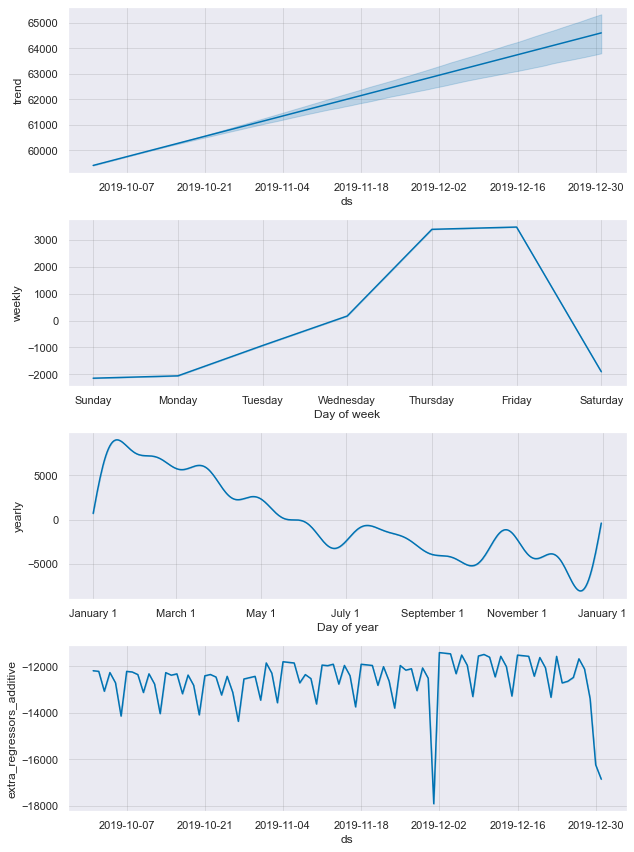

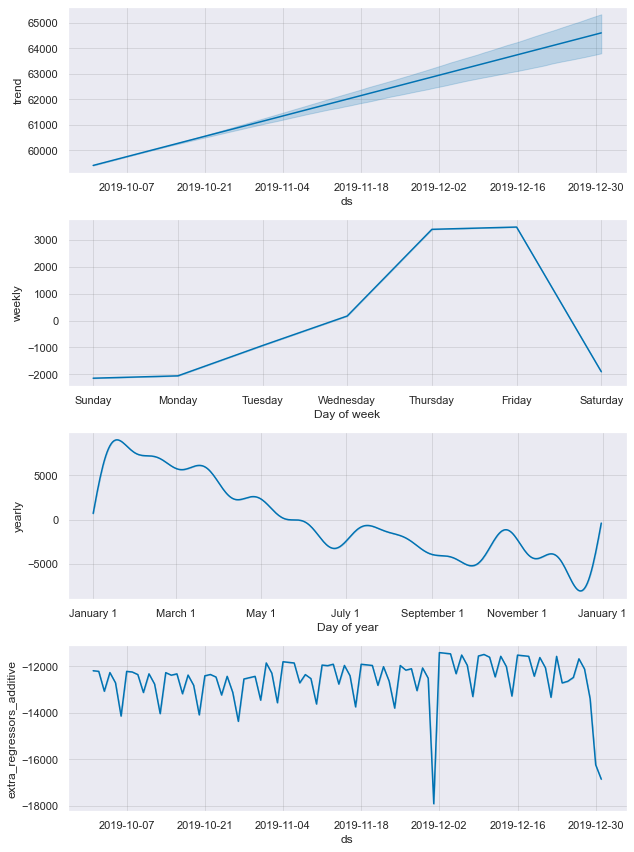

In [265]:
model_fbp.plot_components(forecast)

<AxesSubplot:xlabel='fecha'>

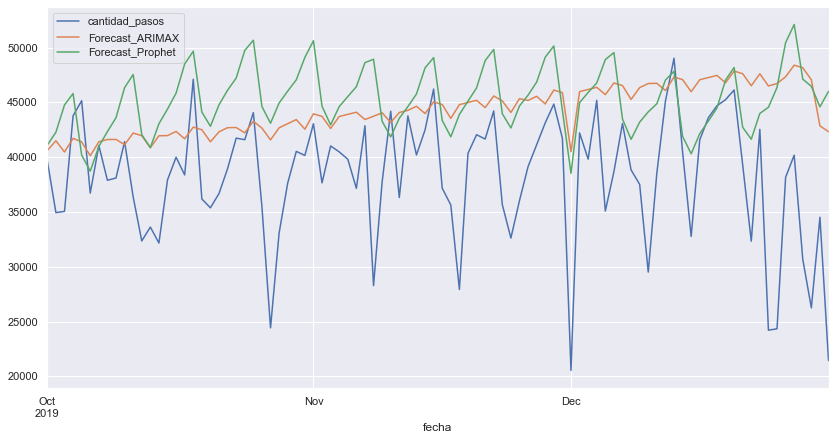

In [266]:
df_valid[["cantidad_pasos", "Forecast_ARIMAX", "Forecast_Prophet"]].plot(figsize=(14, 7))

In [267]:
# report performance
mse = mean_squared_error(df_valid.cantidad_pasos, df_valid.Forecast_Prophet)
print('MSE: '+str(mse))
mae = mean_absolute_error(df_valid.cantidad_pasos, df_valid.Forecast_Prophet)
print('MAE: '+str(mae))
#rmse = math.sqrt(mean_squared_error(test_data, fc))
#print('RMSE: '+str(rmse))
mape = np.mean(np.abs(df_valid.Forecast_Prophet - df_valid.cantidad_pasos)/np.abs(df_valid.cantidad_pasos))
print('MAPE: '+str(mape))

MSE: 80431363.63968603
MAE: 7259.364612413935
MAPE: 0.21966120664680755


In [268]:
print('RMSE:', np.sqrt(metrics.mean_squared_error(df_valid.cantidad_pasos, df_valid.Forecast_Prophet)))

RMSE: 8968.353451982479


In [269]:
from sklearn.metrics import r2_score
print('Prophet')
print('R2 :', r2_score(df_valid.cantidad_pasos, df_valid.Forecast_Prophet))

Prophet
R2 : -1.4185186579407478


Prophet, no mejoró en ninguna metrica en relación a los modelos entrenados en el proyecto 3.

**LightGBM**

En ocasiones, los problemas de series de tiempo se suelen convertir en problemas tipo supervisado para entrenar modelos boosting como son XGBoost o LightGBM.
Hay una pérdida de información en relación de conocer el orden de los puntos de datos en la serie de tiempo, pero se puede evitar mediante la caracterización de la fecha para capturar esta información en cierta medida.

In [197]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Camilo\miniconda3\python.exe -m pip install --upgrade pip' command.


In [270]:
import lightgbm as lgb

In [271]:
params = {"objective": "regression"}

dtrain = lgb.Dataset(df_train[exogenous_features], label=df_train.cantidad_pasos.values)
dvalid = lgb.Dataset(df_valid[exogenous_features])

model_lgb = lgb.train(params, train_set=dtrain)

forecast = model_lgb.predict(df_valid[exogenous_features])
df_valid["Forecast_LightGBM"] = forecast  

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1473
[LightGBM] [Info] Number of data points in the train set: 1003, number of used features: 9
[LightGBM] [Info] Start training from score 44219.071785


<ipython-input-271-cd2a117c7d30>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid["Forecast_LightGBM"] = forecast


<AxesSubplot:xlabel='fecha'>

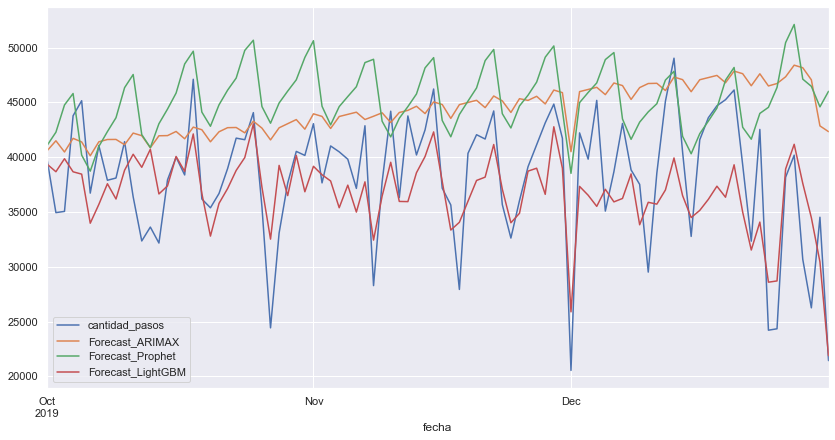

In [272]:
df_valid[["cantidad_pasos", "Forecast_ARIMAX", "Forecast_Prophet", "Forecast_LightGBM"]].plot(figsize=(14, 7))

De la gráfica anterior podemos visualizar que el modelo de LightGBM predice mucho mejor que los modelos de ARIMAX y Prophet. El modelo LightGBM predice de mejor manera el comportaiento de la serie temporal, lo que da razón al comparar las metricas entres estos 3 modelos. 

In [274]:
# report performance
mse = mean_squared_error(df_valid.cantidad_pasos, df_valid.Forecast_LightGBM)
print('MSE: '+str(mse))
mae = mean_absolute_error(df_valid.cantidad_pasos, df_valid.Forecast_LightGBM)
print('MAE: '+str(mae))
#rmse = math.sqrt(mean_squared_error(test_data, fc))
#print('RMSE: '+str(rmse))
mape = np.mean(np.abs(df_valid.Forecast_LightGBM - df_valid.cantidad_pasos)/np.abs(df_valid.cantidad_pasos))
print('MAPE: '+str(mape))

MSE: 19738771.157933064
MAE: 3655.169425595062
MAPE: 0.09835140434023992


In [275]:
print('RMSE:', np.sqrt(metrics.mean_squared_error(df_valid.cantidad_pasos, df_valid.Forecast_LightGBM)))

RMSE: 4442.833685603487


In [276]:
from sklearn.metrics import r2_score
print('LightGBM')
print('R2 :', r2_score(df_valid.cantidad_pasos, df_valid.Forecast_LightGBM))

LightGBM
R2 : 0.4064680222985939


Tabla C: **Cuadro de Resultados de Metricas MSE, MAE, MAPE, R2 Y RMSE con los modelos de Redes Neuronales, y modelos con Variables Exógenas**

|Modelo         |   MSE    |  MAE   | MAPE   |  R2  | RMSE |
|:--------------|:--------:|:------:|:------:|:----:|-----:|
|ARIMA(6,1,7)   |23547549.9|3523.99 |0.122116|0.2991|4852.5|
|**ARIMA(5,1,5)**|**19145490.1**|**3196.01** |**0.116974**|**0.4301**|**4375.5**|
|SARIMA         |34493076.8|4601.94 |0.116974|-0.018|5873.0|
|RandomForest-os|21942432.2|3324.81 |0.098590|0.2283|4684.2|
|RandomForest-ms|23786710.5|3407.70 |0.123032|0.1635|4877.1|  
|Prophet con Fes|39524932.8|4777.67 |0.133219|-0.253|6286.8| 
|Prophet sin Fes|35947219.5|4424.10 |0.101140|-0.140|5995.6| 
|**ARIMA(2,1,2) +** |**12640386.6**|**2608.24** |**0.112749**|**0.5122**|**3555.3**|
|Prophet +      |43559470.2|5047.42 |0.138128|-0.723|6599.9|
|RedNeuronalF   |25636130.0|3516.89 |0.127763|0.0067|5063.2|
|RNN            |35420026.4|4224.31 |0.128347|0.0790|5951.4|
|ARIMAX Vbles Ex|70237867.7|6388.96 |0.198126|-1.112|8380.8|
|Prophet VblesEx|80431363.6|7259.36 |0.219661|-1.418|8968.3|
|**LightGBM**       |**19738771.1**|**3655.16** |**0.098351**|**0.4064**|**4442.8**|

# RESULTADOS

Finalmente, podemos observar que el mejor modelo para este proyecto 4 ha sido el **LightGBM**. Este modelo se acerca a las mejores métricas que se presentaron en el proyecto 3 como son el ARIMA(5,1,5) y el ARIMA(2,1,2). Sin embargo, siendo extricto con la metricas encontradas, el mejor modelo que predice las serie temporal es el **ARIMA(2,1,2)** con información adicional desde el 2009 hasta el 2019. en comparación a los 3 años que tiene el modelo de ARIMA(5,1,5).

Por otro lado, aún podemos probar y mejorar los 5 modelos probados en este proyecto 4 aplicando más información, sumandole más años de registros a los modelos. Esto, de alguna manera puede mejorar las metricas de los modelos de Redes Neuronales, particularmente.